In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import datetime


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import xgboost as xgb

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

/kaggle/input/sparkify-churn/medium-sparkify-event-data.json


# Objective: Businesses are constantly monitoring their churn  since it can deflate earnings reports. For example, Netflix reports net subscribers in order to account for churn.

After determining patterns leading to churn, we make suggestions on how to mitigate them.

Data used is from a music streaming service called Sparkify. 

Sparkify is a hypothetical music streaming company that offers free and paid subscription plans for their customers. The income streams for the company is either paid ads for the free tier or the monthly subscription fee for the paid tier. The company wishes to predict which customers are likely to churn by cancelling their account.

(Caveat about this dataset is that user records have different time ranges.)

In [2]:
df = pd.read_json('../input/sparkify-churn/medium-sparkify-event-data.json', lines=True)                 

# Learning about the Dataset

In [3]:
df.head()  

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1.532064e+12,M,Martin Orford,Grand Designs,597.55057
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1.538070e+12,M,John Brown's Body,Bulls,380.21179
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,Afroman,Because I Got High,202.37016
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1.535931e+12,F,Lily Allen,Smile (Radio Edit),194.53342


In [4]:
df.tail()

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
543700,1543622316000,300010,882,NextSong,Logged In,PUT,200,paid,165,"Dallas-Fort Worth-Arlington, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Jackson,Clayton,1.536850e+12,M,Oliver Onions,Dune Buggy,183.50975
543701,1543622332000,300049,991,NextSong,Logged In,PUT,200,paid,145,"Fresno, CA","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Stewart,Daniel,1.537523e+12,M,Sheena Easton,Strut (1993 Digital Remaster),239.62077
543702,1543622368000,300039,916,NextSong,Logged In,PUT,200,paid,31,"Memphis, TN-MS-AR","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Jenkins,Jeremiah,1.536229e+12,M,The White Stripes,Jolene [Live],234.97098
543703,1543622392000,300038,966,NextSong,Logged In,PUT,200,paid,36,"Lakeland-Winter Haven, FL","""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",Reed,Aiden,1.535616e+12,M,Hinder,Lips Of An Angel,262.05995
543704,1543622401000,300015,981,NextSong,Logged In,PUT,200,paid,109,"San Antonio-New Braunfels, TX","""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",White,Joshua,1.528781e+12,M,Jack Johnson,Do You Remember,144.06485


In [5]:
df.shape

(543705, 18)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543705 entries, 0 to 543704
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ts             543705 non-null  int64  
 1   userId         543705 non-null  object 
 2   sessionId      543705 non-null  int64  
 3   page           543705 non-null  object 
 4   auth           543705 non-null  object 
 5   method         543705 non-null  object 
 6   status         543705 non-null  int64  
 7   level          543705 non-null  object 
 8   itemInSession  543705 non-null  int64  
 9   location       528005 non-null  object 
 10  userAgent      528005 non-null  object 
 11  lastName       528005 non-null  object 
 12  firstName      528005 non-null  object 
 13  registration   528005 non-null  float64
 14  gender         528005 non-null  object 
 15  artist         432877 non-null  object 
 16  song           432877 non-null  object 
 17  length         432877 non-nul

In [7]:
# this is aggregate of all columns that hold numerical values regardless of some being discrete (sessionId)
df.describe()

,ts,sessionId,status,itemInSession,registration,length
count,5.437050e+05,543705.000000,543705.000000,543705.000000,5.280050e+05,432877.000000
mean,1.540965e+12,2040.814353,210.018291,107.306291,1.535523e+12,248.664593
std,1.482057e+09,1434.338931,31.471919,116.723508,3.078725e+09,98.412670
min,1.538352e+12,1.000000,200.000000,0.000000,1.509854e+12,0.783220
25%,1.539720e+12,630.000000,200.000000,26.000000,1.534368e+12,199.392200
50%,1.541005e+12,1968.000000,200.000000,68.000000,1.536556e+12,234.004440
75%,1.542177e+12,3307.000000,200.000000,147.000000,1.537612e+12,276.793020
max,1.543622e+12,4808.000000,404.000000,1005.000000,1.543074e+12,3024.665670


In [8]:
# number of unique values per feature
df.nunique()

ts               513108
userId              449
sessionId          4590
page                 22
auth                  4
method                2
status                3
level                 2
itemInSession      1006
location            192
userAgent            71
lastName            275
firstName           345
registration        448
gender                2
artist            21247
song              80292
length            16679
dtype: int64

## Target column

Page column would have the information that is most pertinent to customer journey. Also, it has the specific page that would inform us whether or not a user churned. That page is called "Cancellation Confirmation".

In [9]:
df.page.value_counts()

NextSong                     432877
Home                          27412
Thumbs Up                     23826
Add to Playlist               12349
Add Friend                     8087
Roll Advert                    7773
Login                          6011
Logout                         5990
Thumbs Down                    4911
Downgrade                      3811
Help                           3150
Settings                       2964
About                          1855
Upgrade                         968
Save Settings                   585
Error                           519
Submit Upgrade                  287
Submit Downgrade                117
Cancel                           99
Cancellation Confirmation        99
Register                         11
Submit Registration               4
Name: page, dtype: int64

## Customer Journey

In [10]:
df.auth.value_counts()

Logged In     527906
Logged Out     15606
Cancelled         99
Guest             94
Name: auth, dtype: int64

In [11]:
df.loc[df['auth'] == 'Logged In']

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1.532064e+12,M,Martin Orford,Grand Designs,597.55057
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1.538070e+12,M,John Brown's Body,Bulls,380.21179
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,Afroman,Because I Got High,202.37016
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1.535931e+12,F,Lily Allen,Smile (Radio Edit),194.53342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543700,1543622316000,300010,882,NextSong,Logged In,PUT,200,paid,165,"Dallas-Fort Worth-Arlington, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Jackson,Clayton,1.536850e+12,M,Oliver Onions,Dune Buggy,183.50975
543701,1543622332000,300049,991,NextSong,Logged In,PUT,200,paid,145,"Fresno, CA","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Stewart,Daniel,1.537523e+12,M,Sheena Easton,Strut (1993 Digital Remaster),239.62077
543702,1543622368000,300039,916,NextSong,Logged In,PUT,200,paid,31,"Memphis, TN-MS-AR","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Jenkins,Jeremiah,1.536229e+12,M,The White Stripes,Jolene [Live],234.97098
543703,1543622392000,300038,966,NextSong,Logged In,PUT,200,paid,36,"Lakeland-Winter Haven, FL","""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",Reed,Aiden,1.535616e+12,M,Hinder,Lips Of An Angel,262.05995


In [12]:
# from sub df with auth = Logged In, any artist rows with NaN?
login = df.loc[df['auth'] == 'Logged In']
login[login['artist'].isna()]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN
10,1538352176000,179,178,Home,Logged In,GET,200,paid,190,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN
12,1538352241000,100,497,Home,Logged In,GET,200,free,0,"Dallas-Fort Worth-Arlington, TX",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,Larson,Colin,1.537982e+12,M,NaN,NaN,NaN
18,1538352336000,163,162,Downgrade,Logged In,GET,200,paid,268,"Rochester, MN","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Gordon,Sofia,1.533176e+12,F,NaN,NaN,NaN
19,1538352376000,179,178,Add to Playlist,Logged In,PUT,200,paid,192,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543673,1543621432000,300015,981,Add to Playlist,Logged In,PUT,200,paid,104,"San Antonio-New Braunfels, TX","""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",White,Joshua,1.528781e+12,M,NaN,NaN,NaN
543678,1543621542000,300010,882,Add to Playlist,Logged In,PUT,200,paid,162,"Dallas-Fort Worth-Arlington, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Jackson,Clayton,1.536850e+12,M,NaN,NaN,NaN
543681,1543621640000,300022,629,Thumbs Up,Logged In,PUT,307,paid,213,"London, KY","""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",Mcintosh,Antonio,1.534461e+12,M,NaN,NaN,NaN
543683,1543621684000,300039,916,Thumbs Up,Logged In,PUT,307,paid,28,"Memphis, TN-MS-AR","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Jenkins,Jeremiah,1.536229e+12,M,NaN,NaN,NaN


In [13]:
#From those who are logged in, what pages are accessible to them?
df.loc[df['auth'] == 'Logged In'].page.value_counts()

NextSong            432877
Thumbs Up            23826
Home                 19089
Add to Playlist      12349
Add Friend            8087
Roll Advert           7773
Logout                5990
Thumbs Down           4911
Downgrade             3811
Settings              2964
Help                  2644
About                 1026
Upgrade                968
Save Settings          585
Error                  503
Submit Upgrade         287
Submit Downgrade       117
Cancel                  99
Name: page, dtype: int64

In [14]:
#From those who are logged out, what pages are accessible to them?
df.loc[df['auth'] == 'Logged Out'].page.value_counts()

Home     8282
Login    6011
About     807
Help      492
Error      14
Name: page, dtype: int64

What pages are not shared between Logged in and Logged Out?

'Login' is the only page not shared between Logged In and Logged Out. This makes sense.

In [15]:
df.loc[df['auth'] == 'Cancelled']

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
2555,1538400616000,208,490,Cancellation Confirmation,Cancelled,GET,200,free,40,"Fort Wayne, IN",Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,Carr,Olivia,1.536758e+12,F,NaN,NaN,NaN
6758,1538482793000,231,471,Cancellation Confirmation,Cancelled,GET,200,paid,234,"Columbus, OH",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Cameron,Lillian,1.533473e+12,F,NaN,NaN,NaN
12652,1538539871000,236,682,Cancellation Confirmation,Cancelled,GET,200,paid,109,"Grand Rapids-Wyoming, MI","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Myers,Alex,1.529996e+12,M,NaN,NaN,NaN
16350,1538592529000,156,628,Cancellation Confirmation,Cancelled,GET,200,free,66,"Bowling Green, KY","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Crawford,Rafael,1.533888e+12,M,NaN,NaN,NaN
29338,1538770077000,271,395,Cancellation Confirmation,Cancelled,GET,200,paid,227,"Roanoke, VA","""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",Stewart,Brad,1.535619e+12,M,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463234,1542206187000,200023,589,Cancellation Confirmation,Cancelled,GET,200,free,11,"New York-Newark-Jersey City, NY-NJ-PA","""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",Daniels,Katiana,1.537813e+12,F,NaN,NaN,NaN
464090,1542360575000,200039,516,Cancellation Confirmation,Cancelled,GET,200,paid,28,"Salt Lake City, UT",Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,Morris,Kaydence,1.534625e+12,F,NaN,NaN,NaN
465426,1542750479000,200020,625,Cancellation Confirmation,Cancelled,GET,200,paid,140,"Orlando-Kissimmee-Sanford, FL",Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,Rivera,Keegan,1.535907e+12,M,NaN,NaN,NaN
499615,1540684960000,300004,289,Cancellation Confirmation,Cancelled,GET,200,paid,35,"Los Angeles-Long Beach-Anaheim, CA","""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",Fischer,Peyton,1.534513e+12,F,NaN,NaN,NaN


In [16]:
df.loc[df['auth'] == 'Guest']

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
30705,1538790047000,,301,Home,Guest,GET,200,free,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74357,1539379125000,,982,Help,Guest,GET,200,free,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74358,1539379130000,,982,Home,Guest,GET,200,free,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74360,1539379141000,,982,About,Guest,GET,200,free,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74361,1539379144000,,982,Home,Guest,GET,200,free,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504997,1541056679000,,51,About,Guest,GET,200,free,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
504998,1541056685000,,51,Home,Guest,GET,200,free,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
504999,1541056703000,,51,Help,Guest,GET,200,free,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505000,1541056710000,,51,Register,Guest,GET,200,free,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#while Guest logged in, any songs played? - No.
guest = df.loc[df['auth'] == 'Guest']
guest.artist.notnull().value_counts()

False    94
Name: artist, dtype: int64

Some intital observations:

* When user is logged in and playing a song, there are no missing values.
* When a user is logged in and not playing a song, *artist, song and length* are missing (This is the same when they cancel their membership).
* When a user is logged out, *location, userAgent, lastName, firstName, registration, gender, artist, song, length* are all missing. (This is the same when Guest is logged in).

Guest column will be eliminated since we are focusing on customer data to determine churn.

In [18]:
df = df.loc[df['auth'] != 'Guest']
df.shape

(543611, 18)

Other eliminations will be for empty string rows in userId column which produce NaN's in song, etc columns. Other NaN's will be left in since other columns in the same row have important data we don't want to throw away just yet.

In [19]:
df.isnull().sum()

ts                    0
userId                0
sessionId             0
page                  0
auth                  0
method                0
status                0
level                 0
itemInSession         0
location          15606
userAgent         15606
lastName          15606
firstName         15606
registration      15606
gender            15606
artist           110734
song             110734
length           110734
dtype: int64

In [20]:
#On top of NaN, we want to check for missing strings
df.eq('').sum()

ts                   0
userId           15606
sessionId            0
page                 0
auth                 0
method               0
status               0
level                0
itemInSession        0
location             0
userAgent            0
lastName             0
firstName            0
registration         0
gender               0
artist               0
song                 0
length               0
dtype: int64

In [21]:
df.loc[df['userId'] == '']

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
6,1538352148000,,178,Home,Logged Out,GET,200,paid,186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1538352151000,,178,Home,Logged Out,GET,200,paid,187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1538352168000,,178,Home,Logged Out,GET,200,paid,188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1538352169000,,178,Login,Logged Out,PUT,307,paid,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,1538353292000,,442,Home,Logged Out,GET,200,free,114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543561,1543617570000,,629,Login,Logged Out,PUT,307,paid,191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543625,1543619604000,,981,Home,Logged Out,GET,200,paid,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543626,1543619605000,,981,Login,Logged Out,PUT,307,paid,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543655,1543620697000,,991,Home,Logged Out,GET,200,paid,135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
blank_userid=df.loc[df['userId'] == '']
blank_userid.artist.notnull().value_counts() #all NaN

False    15606
Name: artist, dtype: int64

In [23]:
#Reminder:
df.shape

(543611, 18)

In [24]:
#Drop UserId rows with empty strings
df['userId'].replace('', np.nan, inplace=True)
df.dropna(subset=['userId'], inplace=True)

In [25]:
df.head(3)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1.532064e+12,M,Martin Orford,Grand Designs,597.55057
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1.538070e+12,M,John Brown's Body,Bulls,380.21179
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,Afroman,Because I Got High,202.37016


In [26]:
df.shape

(528005, 18)

In [27]:
(543611-528005)/543611 #Reduction (Small)

0.028708028351155514

In [28]:
#What sort of information is releveant to churn when auth = 'Logged Out'
df.loc[df['auth'] == 'Logged Out']

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length


Awesome! As soon as empty strings in userId were eliminated, so were all Logged Out entries.

In [29]:
df.auth.value_counts()

Logged In    527906
Cancelled        99
Name: auth, dtype: int64

So all we have left is Logged In and Cancelled which represent non-churn and churnned customers.

# Exploratory Data Analysis (EDA)

The goal here is to first make our target column/feature 'churn'. And given this, we can then go into exploring any correlations with churn. For example, we can see if there is any dip in songs played for those who churn. So let's get started!

## Target Value Column

Reminder: The company wishes to predict which customers are likely to churn by cancelling their account.

Defining churn as df.page = 'Cancellation Confirmation' or 'Cancel'

In [30]:
def churn(row):
    if (row['page'] == 'Cancellation Confirmation')| (row['page'] == 'Cancel'):
        return 1
    else:
        return 0

df['churn'] = df.apply(churn, axis=1)

In [31]:
df.churn.value_counts() #huge class imbalance though reminder that there are many userId duplicates

0    527807
1       198
Name: churn, dtype: int64

In [32]:
df.userId.nunique()

448

In [33]:
#Churn percentage = (churn # / unique users)*100
(df.churn.value_counts().values[1]/df.userId.nunique())*100

44.19642857142857

## Churn Metrics

### Average number of song plays per unique user for those who churned and did not churn

In [34]:
#churn ID's
df.loc[df['churn'] == 1].userId #all unique

2554         208
2555         208
6757         231
6758         231
12641        236
           ...  
465426    200020
499613    300004
499615    300004
499910    300047
499913    300047
Name: userId, Length: 198, dtype: object

In [35]:
#songs played for churn ID's
song_df = df.loc[df['page'] == 'NextSong']
song_df.loc[song_df['userId'].isin(df.loc[df['churn'] == 1].userId)]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length,churn
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1.532064e+12,M,Martin Orford,Grand Designs,597.55057,0
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1.535931e+12,F,Lily Allen,Smile (Radio Edit),194.53342,0
15,1538352318000,246,245,NextSong,Logged In,PUT,200,paid,23,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1.535931e+12,F,Bob Dylan,Simple Twist Of Fate,256.96608,0
17,1538352323000,39,38,NextSong,Logged In,PUT,200,free,83,"Los Angeles-Long Beach-Anaheim, CA","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Campbell,Payton,1.529028e+12,F,Black Kids,Look At Me (When I Rock Wichoo),251.48036,0
27,1538352574000,246,245,NextSong,Logged In,PUT,200,paid,24,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1.535931e+12,F,The Script,Breakeven,260.67546,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499881,1540710689000,300047,258,NextSong,Logged In,PUT,200,paid,30,"Newport, TN",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Jimenez,Addison,1.534487e+12,F,Yellowcard,Martin Sheen Or JFK,226.79465,0
499886,1540710915000,300047,258,NextSong,Logged In,PUT,200,paid,31,"Newport, TN",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Jimenez,Addison,1.534487e+12,F,Travis Tritt,T-R-O-U-B-L-E,181.28934,0
499894,1540711096000,300047,258,NextSong,Logged In,PUT,200,paid,32,"Newport, TN",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Jimenez,Addison,1.534487e+12,F,Racey,Not Too Young To Get Married,182.69995,0
499897,1540711278000,300047,258,NextSong,Logged In,PUT,200,paid,33,"Newport, TN",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Jimenez,Addison,1.534487e+12,F,The Temptations,Santa Claus Is Comin' To Town,205.40036,0


84359 song-plays by those who eventually churn

In [36]:
#non-churn ID's
df.loc[df['churn'] == 0].userId.nunique() #total unique

448

In [37]:
df.loc[df['churn'] == 0].userId.unique() 

array(['293', '98', '179', '246', '163', '175', '100', '39', '147', '196',
       '275', '54', '223', '273', '74', '101', '166', '301', '288', '248',
       '250', '127', '28', '207', '282', '262', '131', '42', '154', '18',
       '142', '45', '95', '78', '87', '51', '236', '251', '126', '85',
       '173', '185', '36', '208', '192', '187', '92', '27', '143', '119',
       '232', '162', '140', '6', '124', '93', '238', '274', '174', '40',
       '113', '167', '170', '25', '137', '65', '241', '172', '53', '299',
       '195', '276', '59', '198', '58', '214', '283', '231', '160', '32',
       '29', '291', '295', '61', '225', '284', '270', '21', '234', '68',
       '132', '156', '219', '86', '136', '80', '296', '110', '182', '130',
       '169', '239', '212', '129', '244', '121', '125', '77', '82', '233',
       '117', '138', '76', '7', '206', '13', '201', '118', '261', '268',
       '258', '16', '226', '105', '96', '57', '115', '164', '211', '221',
       '30', '55', '178', '12', '152', '

In [38]:
# total songs played for non-churn ID's
song_df.loc[song_df['userId'].isin(df.loc[df['churn'] == 0].userId.unique())]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length,churn
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1.532064e+12,M,Martin Orford,Grand Designs,597.55057,0
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1.538070e+12,M,John Brown's Body,Bulls,380.21179,0
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,Afroman,Because I Got High,202.37016,0
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1.535931e+12,F,Lily Allen,Smile (Radio Edit),194.53342,0
5,1538352125000,163,162,NextSong,Logged In,PUT,200,paid,266,"Rochester, MN","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Gordon,Sofia,1.533176e+12,F,Carter USM,Airplane Food,138.29179,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543700,1543622316000,300010,882,NextSong,Logged In,PUT,200,paid,165,"Dallas-Fort Worth-Arlington, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Jackson,Clayton,1.536850e+12,M,Oliver Onions,Dune Buggy,183.50975,0
543701,1543622332000,300049,991,NextSong,Logged In,PUT,200,paid,145,"Fresno, CA","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Stewart,Daniel,1.537523e+12,M,Sheena Easton,Strut (1993 Digital Remaster),239.62077,0
543702,1543622368000,300039,916,NextSong,Logged In,PUT,200,paid,31,"Memphis, TN-MS-AR","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Jenkins,Jeremiah,1.536229e+12,M,The White Stripes,Jolene [Live],234.97098,0
543703,1543622392000,300038,966,NextSong,Logged In,PUT,200,paid,36,"Lakeland-Winter Haven, FL","""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",Reed,Aiden,1.535616e+12,M,Hinder,Lips Of An Angel,262.05995,0


432877 total song plays from those who did not eventually churn.

In [39]:
#count unique users on platform
df.userId.nunique()

448

In [40]:
#songs counts / distinct user count

#churned:
churn_avg_song_count = 84359/99

#non-churned:
non_churn_avg_song_count = 432877/448

In [41]:
#create df with idx as churn (0/1) and avg # songs played-
d = {'churn': ['1', '0'], 'avg_songs_played': [churn_avg_song_count, non_churn_avg_song_count]}
av_song_df = pd.DataFrame(data=d)
av_song_df

,churn,avg_songs_played
0,1,852.111111
1,0,966.243304


In [42]:
import plotly.express as px

fig = px.bar(av_song_df, x='churn', y='avg_songs_played')
fig.show()

### Average hits/page for churned vs non-churned.

In [43]:
#Get df w/o NextSong page
no_nextsong_df = df[df.page != 'NextSong']
no_nextsong_df.head(3)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length,churn
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN,0
10,1538352176000,179,178,Home,Logged In,GET,200,paid,190,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN,0
12,1538352241000,100,497,Home,Logged In,GET,200,free,0,"Dallas-Fort Worth-Arlington, TX",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,Larson,Colin,1.537982e+12,M,NaN,NaN,NaN,0


In [44]:
#get churn userid's from df
churn_id = df.loc[df['churn'] == 1].userId.unique()
churn_id

array(['208', '231', '236', '156', '271', '200', '130', '123', '54', '39',
       '154', '132', '10', '296', '187', '51', '13', '32', '28', '198',
       '196', '172', '189', '234', '16', '214', '246', '88', '45', '61',
       '124', '223', '41', '221', '162', '131', '288', '265', '188',
       '120', '293', '126', '164', '11', '118', '89', '167', '34', '81',
       '18', '85', '140', '100001', '100013', '100030', '100032',
       '100044', '100036', '100023', '100005', '100049', '100018',
       '100047', '100010', '100004', '100038', '100045', '100014',
       '100028', '100016', '100042', '100041', '100040', '100025',
       '100012', '100003', '100048', '100043', '100017', '100024',
       '100051', '100011', '200016', '200037', '200041', '200002',
       '200013', '200021', '200008', '200027', '200050', '200028',
       '200024', '200045', '200023', '200039', '200020', '300004',
       '300047'], dtype=object)

In [45]:
all_id = df.userId.unique()

In [46]:
#get non-churn userid's (all userid's - churn userid's) from df
non_churn_id = []
for i in all_id:
    if i not in churn_id:
        non_churn_id.append(i) 
print(len(non_churn_id)) #expect 448-99=349

349


In [47]:
#get page counts for churn from no_nextsong_df
churn_page_counts = no_nextsong_df.loc[no_nextsong_df['userId'].isin(churn_id)].page.value_counts().sort_index().rename_axis('page').reset_index(name='counts').sort_index()
churn_page_counts['average'] = churn_page_counts['counts']/(df.userId.nunique())
churn_page_counts

,page,counts,average
0,About,185,0.412946
1,Add Friend,1537,3.430804
2,Add to Playlist,2259,5.042411
3,Cancel,99,0.220982
4,Cancellation Confirmation,99,0.220982
5,Downgrade,831,1.854911
6,Error,97,0.216518
7,Help,517,1.154018
8,Home,3778,8.433036
9,Logout,1184,2.642857


In [48]:
#get page counts for non-churn from no_nextsong_df
non_churn_page_counts = no_nextsong_df.loc[no_nextsong_df['userId'].isin(non_churn_id)].page.value_counts().rename_axis('page').reset_index(name='counts').sort_index()
non_churn_page_counts['average'] = non_churn_page_counts['counts']/(df.userId.nunique())
non_churn_page_counts

,page,counts,average
0,Thumbs Up,19526,43.584821
1,Home,15311,34.176339
2,Add to Playlist,10090,22.522321
3,Add Friend,6550,14.620536
4,Roll Advert,5587,12.470982
5,Logout,4806,10.727679
6,Thumbs Down,3755,8.381696
7,Downgrade,2980,6.651786
8,Settings,2345,5.234375
9,Help,2127,4.747768


In [49]:
#make df to plot
page_counts_df = pd.merge(churn_page_counts, non_churn_page_counts, on="page", how="left")
page_counts_df #x = churn, y = non-churn

,page,counts_x,average_x,counts_y,average_y
0,About,185,0.412946,841.0,1.877232
1,Add Friend,1537,3.430804,6550.0,14.620536
2,Add to Playlist,2259,5.042411,10090.0,22.522321
3,Cancel,99,0.220982,NaN,NaN
4,Cancellation Confirmation,99,0.220982,NaN,NaN
5,Downgrade,831,1.854911,2980.0,6.651786
6,Error,97,0.216518,406.0,0.906250
7,Help,517,1.154018,2127.0,4.747768
8,Home,3778,8.433036,15311.0,34.176339
9,Logout,1184,2.642857,4806.0,10.727679


In [50]:
fig = go.Figure()
fig.add_trace(go.Bar(x=page_counts_df.page,
                     y=page_counts_df.average_x,
                     name="Churn"))
fig.add_trace(go.Bar(x=page_counts_df.page,
                     y=page_counts_df.average_y,
                     name="Non-Churn"))

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = page_counts_df.page
        #ticktext = df["CLASS"])
    )
)

Already from this side-by-side there is a telling story. Biggest differences from churn v. non-churn users are amount of times a user added a friend, added a song to a playlist, went to the home page and at the top of the list for main differentiator is how many thumbs up's are given.

### Number of churned users as subscribers v paid subscribers

In [51]:
churn_subs = df.loc[df['userId'].isin(churn_id)].level.value_counts().rename_axis('level').reset_index(name='counts').sort_index()
churn_subs

,level,counts
0,paid,76152
1,free,27494


In [52]:
fig = px.bar(churn_subs, x='level', y='counts')
fig.show()

Most churnned customers were paid which went against my intuition that most customers who leave would have little commitment/ subscription.

### Churn Counts Per Hour

In [53]:
#Create time columns
hour = []
date = []
timestamp = []
for i in df['ts']:
    hour.append(datetime.datetime.fromtimestamp(i/1000.0).hour)
    date.append(datetime.datetime.fromtimestamp(i/1000.0).strftime("%Y-%m-%d"))
    timestamp.append(datetime.datetime.fromtimestamp(i/1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [54]:
df['ts_hour'] = hour
df['ts_date'] = date
df['timestamp'] = timestamp

In [55]:
#churn/cancellation confrimation subset
churn_hours = df.loc[df['page'] == 'Cancellation Confirmation'].ts_hour.value_counts().rename_axis('hour').reset_index(name='counts').sort_index()
churn_hours

,hour,counts
0,3,6
1,16,6
2,10,6
3,13,6
4,12,6
5,0,5
6,20,5
7,18,5
8,9,5
9,22,4


In [56]:
fig = px.bar(churn_hours, x='hour', y='counts')
fig.show()

At hours: 3,10,12,13,and 16 were the most popular hours for churnning. So not too many during mid-afternoon and night time, which is probably the time people need music the most.

### Churn Rate per UserAgent

In [57]:
#Get DF with churn IDs
churn_df = df.loc[(df['page'] == 'Cancellation Confirmation') | (df['page'] == 'Cancel')]

In [58]:
#make new column with UserAgent names only

agent = []
for i in churn_df['userAgent']:
    agent.append(i.split('(')[1].replace(";", " ").split(" ")[0])


churn_df['useragent_short'] = agent
churn_df

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,registration,gender,artist,song,length,churn,ts_hour,ts_date,timestamp,useragent_short
2554,1538400609000,208,490,Cancel,Logged In,PUT,307,free,39,"Fort Wayne, IN",...,1.536758e+12,F,NaN,NaN,NaN,1,13,2018-10-01,2018-10-01 13:30:09,Windows
2555,1538400616000,208,490,Cancellation Confirmation,Cancelled,GET,200,free,40,"Fort Wayne, IN",...,1.536758e+12,F,NaN,NaN,NaN,1,13,2018-10-01,2018-10-01 13:30:16,Windows
6757,1538482775000,231,471,Cancel,Logged In,PUT,307,paid,233,"Columbus, OH",...,1.533473e+12,F,NaN,NaN,NaN,1,12,2018-10-02,2018-10-02 12:19:35,Windows
6758,1538482793000,231,471,Cancellation Confirmation,Cancelled,GET,200,paid,234,"Columbus, OH",...,1.533473e+12,F,NaN,NaN,NaN,1,12,2018-10-02,2018-10-02 12:19:53,Windows
12641,1538539764000,236,682,Cancel,Logged In,PUT,307,paid,108,"Grand Rapids-Wyoming, MI",...,1.529996e+12,M,NaN,NaN,NaN,1,4,2018-10-03,2018-10-03 04:09:24,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465426,1542750479000,200020,625,Cancellation Confirmation,Cancelled,GET,200,paid,140,"Orlando-Kissimmee-Sanford, FL",...,1.535907e+12,M,NaN,NaN,NaN,1,21,2018-11-20,2018-11-20 21:47:59,Macintosh
499613,1540684945000,300004,289,Cancel,Logged In,PUT,307,paid,34,"Los Angeles-Long Beach-Anaheim, CA",...,1.534513e+12,F,NaN,NaN,NaN,1,0,2018-10-28,2018-10-28 00:02:25,Windows
499615,1540684960000,300004,289,Cancellation Confirmation,Cancelled,GET,200,paid,35,"Los Angeles-Long Beach-Anaheim, CA",...,1.534513e+12,F,NaN,NaN,NaN,1,0,2018-10-28,2018-10-28 00:02:40,Windows
499910,1540711797000,300047,258,Cancel,Logged In,PUT,307,paid,36,"Newport, TN",...,1.534487e+12,F,NaN,NaN,NaN,1,7,2018-10-28,2018-10-28 07:29:57,Windows


In [59]:
ua = churn_df['useragent_short'].value_counts().rename_axis('ua').reset_index(name='counts').sort_index()
ua['churn_rate'] = ua['counts']/df.userId.nunique()

In [60]:
ua

,ua,counts,churn_rate
0,Windows,92,0.205357
1,Macintosh,70,0.156250
2,iPhone,22,0.049107
3,X11,10,0.022321
4,compatible,4,0.008929


In [61]:
fig = px.bar(ua, x='ua', y='churn_rate')

fig.update_layout(
    title={
        'text': "Churn Rate v. UserAgent",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Most churns are happening from comp devices. So Engineering might need to look into this in order to see if there is any Prod issue.

# Feature Engineering

Key ideas:
    
* efficiency of model depends heavily on features we engineer/identify
* features that correlate strongly with target var -> high model accuracy
* do not add features that have near 0 correlation (adds noise/muddles model)

* particularly for this problem, it is important to note for those who churned, what are the differences in activity such as engagement with the plaform before signing up for membership and after signing up- e.g. did they take longer to become a member relative to the average time it took for people on the platform?, lingering more on page, etc. These sort of patterns would give way to whether or not a customer is less committed to the service.

First off, in order to separate activities between free and paid membership, 
will concat level and page columns.

In [62]:
df['level_page'] =  df['level'] + ' ' + df['page']
df.head()

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,registration,gender,artist,song,length,churn,ts_hour,ts_date,timestamp,level_page
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX",...,1.532064e+12,M,Martin Orford,Grand Designs,597.55057,0,0,2018-10-01,2018-10-01 00:00:11,free NextSong
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX",...,1.538070e+12,M,John Brown's Body,Bulls,380.21179,0,0,2018-10-01,2018-10-01 00:00:25,free NextSong
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL",...,1.535953e+12,M,Afroman,Because I Got High,202.37016,0,0,2018-10-01,2018-10-01 00:01:58,paid NextSong
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL",...,1.535953e+12,M,NaN,NaN,NaN,0,0,2018-10-01,2018-10-01 00:01:59,paid Logout
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",...,1.535931e+12,F,Lily Allen,Smile (Radio Edit),194.53342,0,0,2018-10-01,2018-10-01 00:02:04,paid NextSong


In [63]:
df.level_page.value_counts()

paid NextSong                     349782
free NextSong                      83095
paid Thumbs Up                     19504
paid Home                          13956
paid Add to Playlist               10033
free Roll Advert                    7337
paid Add Friend                     6341
free Home                           5133
free Thumbs Up                      4322
paid Logout                         4184
paid Downgrade                      3811
paid Thumbs Down                    3771
free Add to Playlist                2316
paid Settings                       2240
paid Help                           2076
free Logout                         1806
free Add Friend                     1746
free Thumbs Down                    1140
free Upgrade                         968
paid About                           827
free Settings                        724
free Help                            568
paid Roll Advert                     436
paid Save Settings                   435
paid Error      

In [64]:
df2 = df.copy()

In [65]:
df2 = df2.drop(columns=['ts',

 'sessionId',
 'page',
 'auth',
 'method',
 'status',
 'level',
 'itemInSession',
 'location',
 'userAgent',
 'lastName',
 'firstName',
 'registration',
 'gender',
 'artist',
 'song',
 'length',
 'churn',
 'ts_hour',
 'ts_date',
 'timestamp'])

In [66]:
df2 = df2.reset_index()

In [67]:
df2

,index,userId,level_page
0,0,293,free NextSong
1,1,98,free NextSong
2,2,179,paid NextSong
3,3,179,paid Logout
4,4,246,paid NextSong
...,...,...,...
528000,543700,300010,paid NextSong
528001,543701,300049,paid NextSong
528002,543702,300039,paid NextSong
528003,543703,300038,paid NextSong


In [68]:
ndf = df2.pivot_table(index='userId', columns='level_page', 
                        aggfunc=len, fill_value=0)
ndf

index                                                   \
level_page free About free Add Friend free Add to Playlist free Cancel   
userId                                                                   
10                  0               0                    0           0   
100                 0               0                    2           0   
100001              1               1                    3           1   
100002              0               0                    1           0   
100003              0               6                    6           0   
...               ...             ...                  ...         ...   
95                  0               0                    0           0   
96                  0               0                    0           0   
97                  6              23                   31           0   
98                  0               2                    2           0   
99                  1              14                    6           0   

                                                                          \
level_page free Cancellation Confirmation free Error free Help free Home   
userId                                                                     
10                                      0          0         0         0   
100                                     0          0         0         3   
100001                                  1          0         1         4   
100002                                  0          0         1         5   
100003                                  0          1         1        10   
...                                   ...        ...       ...       ...   
95                                      0          0         0         0   
96                                      0          0         0         0   
97                                      0          2         9        73   
98                                      0          0         1         5   
99                                      0          0         3        14   

                                      ...                                  \
level_page free Logout free NextSong  ... paid Help paid Home paid Logout   
userId                                ...                                   
10                   0             0  ...         3        15           4   
100                  1            46  ...        17       132          35   
100001               2            96  ...         0         0           0   
100002               2            24  ...         1         7           1   
100003               4           231  ...         2        21           8   
...                ...           ...  ...       ...       ...         ...   
95                   0             0  ...        11        81          17   
96                   0             0  ...        11        84          29   
97                  17          1148  ...         1         2           0   
98                   2            39  ...        17       104          32   
99                   6           342  ...         2        19           3   

                                                                            \
level_page paid NextSong paid Roll Advert paid Save Settings paid Settings   
userId                                                                       
10                   360                0                  0             2   
100                 3336                3                  2            17   
100001                 0                0                  0             0   
100002               113                0                  0             0   
100003               430                4                  1             3   
...                  ...              ...                ...           ...   
95                  2062                4                  5            16   
96                  1950                3              

In [69]:
ndf.reset_index(level=0, inplace=True)
ndf #level_page is index (not counted as column, but shows up as column)

userId      index                                       \
level_page         free About free Add Friend free Add to Playlist   
0               10          0               0                    0   
1              100          0               0                    2   
2           100001          1               1                    3   
3           100002          0               0                    1   
4           100003          0               6                    6   
..             ...        ...             ...                  ...   
443             95          0               0                    0   
444             96          0               0                    0   
445             97          6              23                   31   
446             98          0               2                    2   
447             99          1              14                    6   

                                                                            \
level_page free Cancel free Cancellation Confirmation free Error free Help   
0                    0                              0          0         0   
1                    0                              0          0         0   
2                    1                              1          0         1   
3                    0                              0          0         1   
4                    0                              0          1         1   
..                 ...                            ...        ...       ...   
443                  0                              0          0         0   
444                  0                              0          0         0   
445                  0                              0          2         9   
446                  0                              0          0         1   
447                  0                              0          0         3   

                                  ...                                  \
level_page free Home free Logout  ... paid Help paid Home paid Logout   
0                  0           0  ...         3        15           4   
1                  3           1  ...        17       132          35   
2                  4           2  ...         0         0           0   
3                  5           2  ...         1         7           1   
4                 10           4  ...         2        21           8   
..               ...         ...  ...       ...       ...         ...   
443                0           0  ...        11        81          17   
444                0           0  ...        11        84          29   
445               73          17  ...         1         2           0   
446                5           2  ...        17       104          32   
447               14           6  ...         2        19           3   

                                                                            \
level_page paid NextSong paid Roll Advert paid Save Settings paid Settings   
0                    360                0                  0             2   
1                   3336                3                  2            17   
2                      0                0                  0             0   
3                    113                0                  0             0   
4                    430                4                  1             3   
..                   ...              ...                ...           ...   
443                 2062                4                  5            16   
444                 1950                3                  3             8   
445                   55                0                  0             0   
446                 2648                4                  7            16   
447                  670                0                  0             4   

                                                                  
level_page paid Submit Downgrade paid Thumbs Down paid

In [70]:
#create churn target from 'free Cancellation Confirmation' and 'paid Cancellation Confirmation'
def churn2(row):
    if (row['free Cancellation Confirmation'] == 1) | (row['paid Cancellation Confirmation'] == 1) | (row['free Cancel'] == 1) | (row['paid Cancel'] == 1):
        return 1
    else:
        return 0

ndf['churn'] = ndf.apply(churn2, axis=1)

KeyError: 'free Cancellation Confirmation'

In [71]:
ndf

userId      index                                       \
level_page         free About free Add Friend free Add to Playlist   
0               10          0               0                    0   
1              100          0               0                    2   
2           100001          1               1                    3   
3           100002          0               0                    1   
4           100003          0               6                    6   
..             ...        ...             ...                  ...   
443             95          0               0                    0   
444             96          0               0                    0   
445             97          6              23                   31   
446             98          0               2                    2   
447             99          1              14                    6   

                                                                            \
level_page free Cancel free Cancellation Confirmation free Error free Help   
0                    0                              0          0         0   
1                    0                              0          0         0   
2                    1                              1          0         1   
3                    0                              0          0         1   
4                    0                              0          1         1   
..                 ...                            ...        ...       ...   
443                  0                              0          0         0   
444                  0                              0          0         0   
445                  0                              0          2         9   
446                  0                              0          0         1   
447                  0                              0          0         3   

                                  ...                                  \
level_page free Home free Logout  ... paid Help paid Home paid Logout   
0                  0           0  ...         3        15           4   
1                  3           1  ...        17       132          35   
2                  4           2  ...         0         0           0   
3                  5           2  ...         1         7           1   
4                 10           4  ...         2        21           8   
..               ...         ...  ...       ...       ...         ...   
443                0           0  ...        11        81          17   
444                0           0  ...        11        84          29   
445               73          17  ...         1         2           0   
446                5           2  ...        17       104          32   
447               14           6  ...         2        19           3   

                                                                            \
level_page paid NextSong paid Roll Advert paid Save Settings paid Settings   
0                    360                0                  0             2   
1                   3336                3                  2            17   
2                      0                0                  0             0   
3                    113                0                  0             0   
4                    430                4                  1             3   
..                   ...              ...                ...           ...   
443                 2062                4                  5            16   
444                 1950                3                  3             8   
445                   55                0                  0             0   
446                 2648                4                  7            16   
447                  670                0                  0             4   

                                                                  
level_page paid Submit Downgrade paid Thumbs Down paid

In [72]:
#Drop irrelevant columns as prep for creating independent and target variables
ndf = ndf.drop(columns= ['free Cancellation Confirmation', 'free Cancel', 'paid Cancellation Confirmation', 'paid Cancel'])
ndf

KeyError: 'free Cancellation Confirmation'

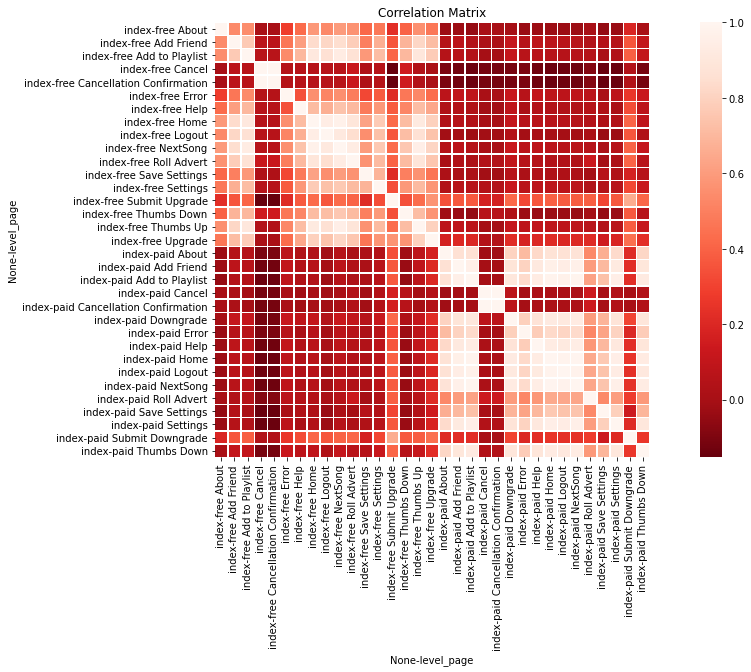

In [73]:
#create heatmap to understand correlation between var's in independent var's
independent_var = ndf.columns
independent_var = independent_var[:-1]

# target variable is renamed as label
ndf = ndf.rename(columns={'churn': 'label'})

fig = plt.figure(figsize=(18,8))
ax = plt.gca()
ax.set_title("Correlation Matrix")
sns.heatmap(ndf[independent_var].corr(), annot = False, \
                                    linewidths=0.5, square = True, cmap = 'Reds_r')

In [74]:
ndf_corr = ndf.corr()
ndf_corr

index                  \
level_page                           free About free Add Friend   
      level_page                                                  
index free About                       1.000000        0.538621   
      free Add Friend                  0.538621        1.000000   
      free Add to Playlist             0.549647        0.768579   
      free Cancel                      0.007856        0.072557   
      free Cancellation Confirmation   0.007856        0.072557   
      free Error                       0.281151        0.465825   
      free Help                        0.430630        0.609941   
      free Home                        0.586415        0.840855   
      free Logout                      0.533289        0.819536   
      free NextSong                    0.595814        0.847933   
      free Roll Advert                 0.567081        0.780306   
      free Save Settings               0.416658        0.495692   
      free Settings                    0.477591        0.668206   
      free Submit Upgrade              0.227092        0.360375   
      free Thumbs Down                 0.400954        0.687340   
      free Thumbs Up                   0.559860        0.819439   
      free Upgrade                     0.469577        0.717843   
      paid About                      -0.023118        0.051743   
      paid Add Friend                 -0.024096        0.077192   
      paid Add to Playlist            -0.040988        0.047974   
      paid Cancel                      0.008945        0.018704   
      paid Cancellation Confirmation   0.008945        0.018704   
      paid Downgrade                  -0.000398        0.110787   
      paid Error                      -0.032039        0.058393   
      paid Help                       -0.024893        0.085225   
      paid Home                       -0.029298        0.072909   
      paid Logout                     -0.030329        0.069663   
      paid NextSong                   -0.029052        0.066149   
      paid Roll Advert                 0.000457        0.044755   
      paid Save Settings              -0.046558        0.047345   
      paid Settings                   -0.031298        0.053580   
      paid Submit Downgrade            0.192512        0.358695   
      paid Thumbs Down                 0.004932        0.102967   
      paid Thumbs Up                  -0.052079        0.032243   

                                                                       \
level_page                           free Add to Playlist free Cancel   
      level_page                                                        
index free About                                 0.549647    0.007856   
      free Add Friend                            0.768579    0.072557   
      free Add to Playlist                       1.000000    0.066893   
      free Cancel                                0.066893    1.000000   
      free Cancellation Confirmation             0.066893    1.000000   
      free Error                                 0.536288    0.054149   
      free Help                                  0.702367    0.059575   
      free Home                                  0.912092    0.055735   
      free Logout                                0.864012    0.061459   
      free NextSong                              0.934834    0.063787   
      free Roll Advert                           0.867929    0.125156   
      free Save Settings                         0.588678    0.027783   
      free Settings                              0.718389    0.057895   
      free Submit Upgrade                        0.405868   -0.152827   
      free Thumbs Down                           0.699028    0.146548   
      free Thumbs Up                             0.902144    0.042800   
      free Upgrade                               0.779327    0.013166   
      paid About                                 0.053913   -0.102617   
      paid Add Friend        

In [75]:
#drop columns that have high correlation that are outside of diagonal. if there is a pair that is close to 1, drop one of the columns.
#removing these columns takes care of redundancy and creates stronger predictive power
#any that have color close to light diagonal
ndf = ndf.drop(columns =['free NextSong', 'paid Home', 'paid Logout', 'paid Add to Playlist'])

KeyError: 'free NextSong'

Creating new features that have strong correlation to label
1. Number of days as free user
1. Number of sessions as free user
1. Average time spent in session by users
1. Average number of songs played per session

These are of interest because they seem to be telling differences between free and paid users.

### Number days as free user

In [76]:
free_df = df.loc[df['level'] == 'free']

max_date = free_df.groupby('userId')['ts_date'].max().reset_index()
max_date.columns = ['userId', 'Max_date']
max_date

,userId,Max_date
0,100,2018-10-02
1,100001,2018-10-02
2,100002,2018-11-02
3,100003,2018-10-27
4,100004,2018-10-14
...,...,...
365,93,2018-10-20
366,94,2018-11-05
367,97,2018-11-29
368,98,2018-10-10


In [77]:
#min_date
min_date = free_df.groupby('userId')['ts_date'].min().reset_index()
min_date.columns = ['userId', 'Min_date']
min_date 

,userId,Min_date
0,100,2018-10-01
1,100001,2018-10-01
2,100002,2018-10-09
3,100003,2018-10-09
4,100004,2018-10-03
...,...,...
365,93,2018-10-01
366,94,2018-10-07
367,97,2018-10-06
368,98,2018-10-01


In [78]:
#datediff's
dates = pd.merge(max_date,min_date, on="userId")
dates

,userId,Max_date,Min_date
0,100,2018-10-02,2018-10-01
1,100001,2018-10-02,2018-10-01
2,100002,2018-11-02,2018-10-09
3,100003,2018-10-27,2018-10-09
4,100004,2018-10-14,2018-10-03
...,...,...,...
365,93,2018-10-20,2018-10-01
366,94,2018-11-05,2018-10-07
367,97,2018-11-29,2018-10-06
368,98,2018-10-10,2018-10-01


In [79]:
dates[['Max_date','Min_date']] = dates[['Max_date','Min_date']].apply(pd.to_datetime) 
dates['days_free'] = (dates['Max_date'] - dates['Min_date']).dt.days
dates

,userId,Max_date,Min_date,days_free
0,100,2018-10-02,2018-10-01,1
1,100001,2018-10-02,2018-10-01,1
2,100002,2018-11-02,2018-10-09,24
3,100003,2018-10-27,2018-10-09,18
4,100004,2018-10-14,2018-10-03,11
...,...,...,...,...
365,93,2018-10-20,2018-10-01,19
366,94,2018-11-05,2018-10-07,29
367,97,2018-11-29,2018-10-06,54
368,98,2018-10-10,2018-10-01,9


In [80]:
#left join ndf with this df.days_free on userId
days_free = pd.merge(ndf, dates, on="userId", how="left")
days_free = days_free.drop(columns = ['Max_date', 'Min_date'])
days_free

,userId,"(userId, )","(index, free About)","(index, free Add Friend)","(index, free Add to Playlist)","(index, free Cancel)","(index, free Cancellation Confirmation)","(index, free Error)","(index, free Help)","(index, free Home)",...,"(index, paid Home)","(index, paid Logout)","(index, paid NextSong)","(index, paid Roll Advert)","(index, paid Save Settings)","(index, paid Settings)","(index, paid Submit Downgrade)","(index, paid Thumbs Down)","(index, paid Thumbs Up)",days_free
0,10,10,0,0,0,0,0,0,0,0,...,15,4,360,0,0,2,0,1,17,NaN
1,100,100,0,0,2,0,0,0,0,3,...,132,35,3336,3,2,17,0,37,142,1.0
2,100001,100001,1,1,3,1,1,0,1,4,...,0,0,0,0,0,0,0,0,0,1.0
3,100002,100002,0,0,1,0,0,0,1,5,...,7,1,113,0,0,0,1,2,5,24.0
4,100003,100003,0,6,6,0,0,1,1,10,...,21,8,430,4,1,3,0,3,10,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,95,95,0,0,0,0,0,0,0,0,...,81,17,2062,4,5,16,0,21,122,NaN
444,96,96,0,0,0,0,0,0,0,0,...,84,29,1950,3,3,8,0,20,78,NaN
445,97,97,6,23,31,0,0,2,9,73,...,2,0,55,0,0,0,0,1,4,54.0
446,98,98,0,2,2,0,0,0,1,5,...,104,32,2648,4,7,16,0,31,129,9.0


In [81]:
#sanity check (null should be 448-370=78)
days_free.days_free.isnull().sum()

78

### Sessions as free user

In [82]:
sessions_free= free_df.groupby('userId').agg({'sessionId': 'count', 'sessionId': 'nunique'}).reset_index()
sessions_free.columns = ['userId', 'dist_sessions_ct']
sessions_free

,userId,dist_sessions_ct
0,100,2
1,100001,3
2,100002,3
3,100003,5
4,100004,5
...,...,...
365,93,4
366,94,6
367,97,29
368,98,6


In [83]:
#left join sessions to ndf
sessions_free2 = pd.merge(days_free, sessions_free, on="userId", how="left")
sessions_free2

,userId,"(userId, )","(index, free About)","(index, free Add Friend)","(index, free Add to Playlist)","(index, free Cancel)","(index, free Cancellation Confirmation)","(index, free Error)","(index, free Help)","(index, free Home)",...,"(index, paid Logout)","(index, paid NextSong)","(index, paid Roll Advert)","(index, paid Save Settings)","(index, paid Settings)","(index, paid Submit Downgrade)","(index, paid Thumbs Down)","(index, paid Thumbs Up)",days_free,dist_sessions_ct
0,10,10,0,0,0,0,0,0,0,0,...,4,360,0,0,2,0,1,17,NaN,NaN
1,100,100,0,0,2,0,0,0,0,3,...,35,3336,3,2,17,0,37,142,1.0,2.0
2,100001,100001,1,1,3,1,1,0,1,4,...,0,0,0,0,0,0,0,0,1.0,3.0
3,100002,100002,0,0,1,0,0,0,1,5,...,1,113,0,0,0,1,2,5,24.0,3.0
4,100003,100003,0,6,6,0,0,1,1,10,...,8,430,4,1,3,0,3,10,18.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,95,95,0,0,0,0,0,0,0,0,...,17,2062,4,5,16,0,21,122,NaN,NaN
444,96,96,0,0,0,0,0,0,0,0,...,29,1950,3,3,8,0,20,78,NaN,NaN
445,97,97,6,23,31,0,0,2,9,73,...,0,55,0,0,0,0,1,4,54.0,29.0
446,98,98,0,2,2,0,0,0,1,5,...,32,2648,4,7,16,0,31,129,9.0,6.0


In [84]:
#sanity check
sessions_free2.dist_sessions_ct.isnull().sum()

78

### Average time spent in session

In [85]:
#get time diff per distinct user
#divide time diff by count(dist sessions) per distinct user

max_ts = free_df.groupby('userId')['timestamp'].max().reset_index()
max_ts.columns = ['userId', 'Max_ts']
max_ts

,userId,Max_ts
0,100,2018-10-02 10:54:43
1,100001,2018-10-02 14:50:59
2,100002,2018-11-02 08:17:40
3,100003,2018-10-27 22:19:47
4,100004,2018-10-14 10:13:00
...,...,...
365,93,2018-10-20 10:53:24
366,94,2018-11-05 10:31:14
367,97,2018-11-29 02:50:53
368,98,2018-10-10 12:52:28


In [86]:
min_ts = free_df.groupby('userId')['timestamp'].min().reset_index()
min_ts.columns = ['userId', 'Min_ts']
min_ts

,userId,Min_ts
0,100,2018-10-01 00:04:01
1,100001,2018-10-01 06:48:24
2,100002,2018-10-09 19:28:59
3,100003,2018-10-09 15:53:40
4,100004,2018-10-03 02:47:15
...,...,...
365,93,2018-10-01 16:01:26
366,94,2018-10-07 03:00:11
367,97,2018-10-06 21:36:24
368,98,2018-10-01 00:00:25


In [87]:
ts = pd.merge(max_ts,min_ts, on="userId")
ts

,userId,Max_ts,Min_ts
0,100,2018-10-02 10:54:43,2018-10-01 00:04:01
1,100001,2018-10-02 14:50:59,2018-10-01 06:48:24
2,100002,2018-11-02 08:17:40,2018-10-09 19:28:59
3,100003,2018-10-27 22:19:47,2018-10-09 15:53:40
4,100004,2018-10-14 10:13:00,2018-10-03 02:47:15
...,...,...,...
365,93,2018-10-20 10:53:24,2018-10-01 16:01:26
366,94,2018-11-05 10:31:14,2018-10-07 03:00:11
367,97,2018-11-29 02:50:53,2018-10-06 21:36:24
368,98,2018-10-10 12:52:28,2018-10-01 00:00:25


In [88]:
ts[['Max_ts','Min_ts']] = ts[['Max_ts','Min_ts']].apply(pd.to_datetime)

ts['ts_hours_free'] = ((ts['Max_ts'] - ts['Min_ts']).dt.seconds)/(60*60)
ts=ts.drop(columns=['Max_ts', 'Min_ts'])
#add dist sessions count to get average time spent
ts = pd.merge(sessions_free,ts, on="userId")
ts

,userId,dist_sessions_ct,ts_hours_free
0,100,2,10.845000
1,100001,3,8.043056
2,100002,3,12.811389
3,100003,5,6.435278
4,100004,5,7.429167
...,...,...,...
365,93,4,18.866111
366,94,6,7.517500
367,97,29,5.241389
368,98,6,12.867500


In [89]:
ts['av_session_hrs'] = ts['ts_hours_free']/ts['dist_sessions_ct']
ts = ts.drop(columns = ['dist_sessions_ct', 'ts_hours_free'])
ts

,userId,av_session_hrs
0,100,5.422500
1,100001,2.681019
2,100002,4.270463
3,100003,1.287056
4,100004,1.485833
...,...,...
365,93,4.716528
366,94,1.252917
367,97,0.180738
368,98,2.144583


In [90]:
tshrs_free = pd.merge(sessions_free2, ts, on="userId", how="left")
tshrs_free

,userId,"(userId, )","(index, free About)","(index, free Add Friend)","(index, free Add to Playlist)","(index, free Cancel)","(index, free Cancellation Confirmation)","(index, free Error)","(index, free Help)","(index, free Home)",...,"(index, paid NextSong)","(index, paid Roll Advert)","(index, paid Save Settings)","(index, paid Settings)","(index, paid Submit Downgrade)","(index, paid Thumbs Down)","(index, paid Thumbs Up)",days_free,dist_sessions_ct,av_session_hrs
0,10,10,0,0,0,0,0,0,0,0,...,360,0,0,2,0,1,17,NaN,NaN,NaN
1,100,100,0,0,2,0,0,0,0,3,...,3336,3,2,17,0,37,142,1.0,2.0,5.422500
2,100001,100001,1,1,3,1,1,0,1,4,...,0,0,0,0,0,0,0,1.0,3.0,2.681019
3,100002,100002,0,0,1,0,0,0,1,5,...,113,0,0,0,1,2,5,24.0,3.0,4.270463
4,100003,100003,0,6,6,0,0,1,1,10,...,430,4,1,3,0,3,10,18.0,5.0,1.287056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,95,95,0,0,0,0,0,0,0,0,...,2062,4,5,16,0,21,122,NaN,NaN,NaN
444,96,96,0,0,0,0,0,0,0,0,...,1950,3,3,8,0,20,78,NaN,NaN,NaN
445,97,97,6,23,31,0,0,2,9,73,...,55,0,0,0,0,1,4,54.0,29.0,0.180738
446,98,98,0,2,2,0,0,0,1,5,...,2648,4,7,16,0,31,129,9.0,6.0,2.144583


### Average number of songs played per session

In [91]:
#get song counts per distint userId
#add dist sessions count
#get average song counts per distinct session counts
#drop prelim calc columns
#merge with last merged df to free_df

songs_free= free_df.groupby('userId').agg({'song': 'count'}).reset_index()
songs_free.columns = ['userId', 'songs_ct']
songs_free

,userId,songs_ct
0,100,46
1,100001,96
2,100002,24
3,100003,231
4,100004,262
...,...,...
365,93,196
366,94,56
367,97,1148
368,98,39


In [92]:
songs_free = pd.merge(sessions_free,songs_free, on="userId")
songs_free['av_session_songs'] = songs_free['songs_ct']/songs_free['dist_sessions_ct']
songs_free = songs_free.drop(columns=['dist_sessions_ct', 'songs_ct'])
songs_free

,userId,av_session_songs
0,100,23.000000
1,100001,32.000000
2,100002,8.000000
3,100003,46.200000
4,100004,52.400000
...,...,...
365,93,49.000000
366,94,9.333333
367,97,39.586207
368,98,6.500000


In [93]:
final_df = pd.merge(tshrs_free, songs_free, on="userId", how="left")
final_df

,userId,"(userId, )","(index, free About)","(index, free Add Friend)","(index, free Add to Playlist)","(index, free Cancel)","(index, free Cancellation Confirmation)","(index, free Error)","(index, free Help)","(index, free Home)",...,"(index, paid Roll Advert)","(index, paid Save Settings)","(index, paid Settings)","(index, paid Submit Downgrade)","(index, paid Thumbs Down)","(index, paid Thumbs Up)",days_free,dist_sessions_ct,av_session_hrs,av_session_songs
0,10,10,0,0,0,0,0,0,0,0,...,0,0,2,0,1,17,NaN,NaN,NaN,NaN
1,100,100,0,0,2,0,0,0,0,3,...,3,2,17,0,37,142,1.0,2.0,5.422500,23.000000
2,100001,100001,1,1,3,1,1,0,1,4,...,0,0,0,0,0,0,1.0,3.0,2.681019,32.000000
3,100002,100002,0,0,1,0,0,0,1,5,...,0,0,0,1,2,5,24.0,3.0,4.270463,8.000000
4,100003,100003,0,6,6,0,0,1,1,10,...,4,1,3,0,3,10,18.0,5.0,1.287056,46.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,95,95,0,0,0,0,0,0,0,0,...,4,5,16,0,21,122,NaN,NaN,NaN,NaN
444,96,96,0,0,0,0,0,0,0,0,...,3,3,8,0,20,78,NaN,NaN,NaN,NaN
445,97,97,6,23,31,0,0,2,9,73,...,0,0,0,0,1,4,54.0,29.0,0.180738,39.586207
446,98,98,0,2,2,0,0,0,1,5,...,4,7,16,0,31,129,9.0,6.0,2.144583,6.500000


In [94]:
final_df=final_df.fillna(0)

448 rows of training data is not a huge amount, but let's see what we get with model's performace on test data.

# Modeling

In [95]:
#Data prep
X = final_df.drop(columns=['userId', 'label'])
y = final_df.label

KeyError: "['label'] not found in axis"

In [96]:
#Train / Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

NameError: name 'X' is not defined

In [97]:
print(X_train.shape)
print(X_test.shape)

NameError: name 'X_train' is not defined

## Logistic Regression

In [98]:
CLF = LogisticRegression(C=1.0)
CLF.fit(X_train, y_train)
predictions = CLF.predict(X_test)


print(classification_report(y_test, predictions))

NameError: name 'X_train' is not defined

In [99]:
confusion_matrix(y_test, predictions)

NameError: name 'y_test' is not defined

In [100]:
#Reminder of churn distribution in test data
y_test.value_counts()

NameError: name 'y_test' is not defined

In order to determine the success metric, we have to determine what is the worst case scenario given the business question. Would it be worse to have more false negatives (false non-churn) or false positives (false churnned). Usually, in a business context, it comes down to cost. How much would the business lose if they missed those who were going to churn versus incorrectly trying to win back those who are churnning. It would be more costly to miss those who are churnning since revenue from subscriptions would be lost versus an email being sent to someone who was not actually a churner.

Therefore, success metric is going to be f1-score of minority class (1- churn) and the total number of incorrect predictions from the model with specific attention paid to false negatives (want to catch as many churnners as possible).

So we can see here that f1-score for minority class is only .5. And total incorrectly classified predictions are 20 with 16 as false negatives. Let's see if we can do better with other baseline models like Naive Bayes.

## Naive Bayes

In [101]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print (classification_report(y_test, predictions))

NameError: name 'X_train' is not defined

In [102]:
confusion_matrix(y_test, predictions)

NameError: name 'y_test' is not defined

We can see here that Naive Bayes did worse since it has lower f1-score in minority class and total incorrect predictions more than doubled to 42. Though number of false negatives dropped to 11. Still, rather have higher f1 and less incorrect predictions in total. Let's see if SVM does any better.

## Support Vector Machines

In [103]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
predictons = clf.predict(X_test)

print (classification_report(y_test, predictions))

NameError: name 'X_train' is not defined

In [104]:
confusion_matrix(y_test, predictions)

NameError: name 'y_test' is not defined

## XGBoost

In [105]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print (classification_report(y_test, predictions))

NameError: name 'X_train' is not defined

In [106]:
confusion_matrix(y_test, predictions)

NameError: name 'y_test' is not defined

Though XGBoost usually is the winner, reason for it not being the best is that Logistic Regression in general does well.  That is why each of the model's performance are comparable:

* f1-score: XGBoost was .03 less than Log Reg
* total incorrect: XGBoost has 3 more
* false negatives: tied

In order to increase XGBoost performance, would need to try different parameters. Also, would need to get more training data/better training data where class imbalance is not so severe as well as engineer more features.

## Feature Importance

In order to determine which feature contributed most to churn, would need to see which of the features had the highest coefficient. So let's check it out from our Logistic Regression model.


In [107]:
#greatest coefficient val from all 30 features
for i in CLF.coef_:
    print(max(i))

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [108]:
#feature index of greatest feature contributor
for i in CLF.coef_:
    i = list(i)
    print(i.index(0.1979747673465799, 0,29))

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [109]:
#most important feature
list(X)[20]

NameError: name 'X' is not defined

In [110]:
for i in CLF.coef_:
 
    for idx,v in enumerate(list(i)):
        print('Feature: %0d, Score: %.5f' % (idx,v))

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [111]:
d = {'Feature': list(X), 'Coefficient': CLF.coef_[0]}
df = pd.DataFrame(data=d)
df = df.sort_values(['Coefficient'], ascending=[False])
df

NameError: name 'X' is not defined

In [112]:
plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Coefficient', data=df)
plt.title('Feature importance', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.yticks(fontsize=14);

ValueError: Could not interpret input 'Feature'

<Figure size 1440x360 with 0 Axes>

On the other side of the spectrum is number of days free for users who have not subscribed.

# Conclusion: 

Logistic Regression is the winner! It predicts 16/90 = 17% incorrectly/83% correctly.  This would be the model of choice in order to predict Sparkify customers who churn. 

Also, this model's greatest contributor to predicting churn turns out to be paid Roll Advert. This means that paid subscribers churned the most when showed rolling advertisements. 

# Potential Remediation:

For paid customers: 

1. Decrease advertising length for paid customers
1. Decrease number of advertisements shown to paid customers
1. Introduce incentive for those who stay on platform longer

# Lifetime Value:

To keep customers on the platform, would be good idea to give those who have been on the plaform for a while some exclusive give-a-ways, powerful recommendations to keep them on the platform.